## Read in our data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
df = pd.read_csv('data/tracks_w_lang.csv')

#Get all songs that are in English
df = df[df['lang'] == 'en']
df.head()

,Unnamed: 0,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,...,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,lang
6,6,0.956,"['Franz Liszt', 'Vladimir Horowitz']",0.444,136627,0.19700,0,6O0puPuyrxPjDTHDUgsWI7,0.435000,11,...,-17.226,1,"Valse oubliée No. 1 in F-Sharp Major, S. 215/1",0,1928,0.0400,80.495,0.305,1928,en
14,14,0.977,"['Ludwig van Beethoven', 'Staatskapelle Berlin...",0.335,276563,0.10500,0,6Rwn56jcC0TdGQzbRl7NGw,0.840000,5,...,-16.049,0,"Symphony No. 5 in C Minor, Op. 67: 3. Allegro",0,1928-01-01,0.0716,80.204,0.406,1928,en
15,15,0.991,"['George Butterworth', 'John Cameron']",0.319,184840,0.00593,0,6Sdpmree8xpGWaedACPMlP,0.000063,7,...,-25.789,0,A Shropshire Lad: Is My Team Ploughing?,0,1928,0.0510,79.831,0.169,1928,en
18,18,0.993,"['Thomas Arne', 'John Heddle Nash']",0.569,122533,0.15000,0,6UUfiNT82MWBNnmsE2ZNWf,0.001500,5,...,-15.238,1,Where the Bee Sucks,0,1928,0.0474,76.930,0.596,1928,en
22,22,0.975,"['Frédéric Chopin', 'Vladimir Horowitz']",0.277,245440,0.09000,0,6VUm7Dg5sufmG01IYcoJE3,0.949000,7,...,-26.188,1,"Andante spianato in E-Flat Major, Op. 22",0,1928,0.0316,105.031,0.168,1928,en


In [3]:
df.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,89992.000000,89992.000000,89992.000000,8.999200e+04,89992.00000,89992.000000,89992.000000,89992.000000,89992.000000,89992.000000,89992.000000,89992.000000,89992.000000,89992.000000,89992.000000,89992.000000
mean,84493.669704,0.448343,0.531137,2.370116e+05,0.51115,0.078240,0.146098,5.170126,0.210824,-11.121139,0.720753,34.423515,0.077090,117.692829,0.517083,1980.479720
std,48822.253060,0.367217,0.176143,1.235267e+05,0.26819,0.268551,0.295994,3.513963,0.188522,5.487447,0.448632,19.424042,0.101804,30.552289,0.259888,23.037846
min,6.000000,0.000000,0.000000,5.991000e+03,0.00000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,42873.750000,0.068700,0.411000,1.732670e+05,0.28900,0.000000,0.000000,2.000000,0.097200,-14.046000,0.000000,21.000000,0.034000,94.292750,0.307000,1963.000000
50%,83642.500000,0.403000,0.541000,2.156230e+05,0.51400,0.000000,0.000155,5.000000,0.134000,-10.319000,1.000000,35.000000,0.043000,115.468500,0.524000,1980.000000
75%,125972.250000,0.826000,0.658000,2.699730e+05,0.73400,0.000000,0.050000,8.000000,0.263000,-7.051000,1.000000,48.000000,0.068500,136.570000,0.731000,2000.000000
max,169908.000000,0.996000,0.988000,5.403500e+06,1.00000,1.000000,1.000000,11.000000,1.000000,3.744000,1.000000,100.000000,0.967000,244.091000,1.000000,2020.000000


## Feature Generation
### Perform PCA on Each Decade and then do KMeans Clustering to identify groups of songs

In [4]:
#Helper function to normalize all the columns of a matrix

def normalize_cols(X, m = None, s = None):
    """
    Z-score normalizes all columns in matrix X
    
    Returns the new z_scored matrix X_n
    """
    nrows, ncols = X.shape
    X_n = np.zeros((nrows, ncols))
    ms = []
    ss = []
    for i in range(ncols):
        if m is None:
            mean = X[:,i].mean()
        else:
            mean = m[i]
        if s is None:
            std = X[:,i].std()
        else:
            std = s[i]
        X_n[:,i] = (X[:,i] - mean) / std
        ms.append(mean)
        ss.append(ss)
    return X_n, ms, ss

In [5]:
summary = df.describe()
start_dec = round(int(summary.at['min', 'year']), -1)
last_dec = round(int(summary.at['max','year']), -1)

def PCA_and_KMeans(df, start_dec, last_dec):
    """
    This function takes our dataframe df and performs the following for each
    individual decade:
    
    1. Perform PCA with an increasing number of principal components until we
    get 95% of the variance covered. Once we reach this threshold, we retain
    this transformed data in a variable called X_new. We add a tuple containing
    the pca model and the transformed data matrix in the pcas dictionary corresponding
    to the key representing its decade
    
    2. Perform K-Means Clustering with 10, 12, 14, and 16 clusters on the transformed data.
    A dictionary containing cluster numbers corresponding to predicted labels will be added
    to the kmeans dictionary for the given decade.
    
    Returns:
    pcas - A dictionary containing {'decade':(pca_model, transformed_X)} pairs
    kmeans - A dictionary containing {'decade':{n_clusters:pred_labels__for_n_clusters}} pairs
    dfs - A dictionary containing {decade:[non-normalized_df, normalized_df]} pairs
    """
    pcas = {}
    kmeans = {}
    dfs = {}
    for dec in range(start_dec, last_dec, 10):
        key = str(dec) + '\'s'
        
        decade_df = df[df['year'] >= dec]
        decade_df = decade_df[decade_df['year'] < (dec + 10)]
        decade_df = decade_df.drop(labels = ['explicit', 'mode', 'year'], axis = 1)
        
        #Isolate a target variable, which is popularity
        target = decade_df['popularity']
        decade_df.drop('popularity', axis = 1)
        dfs[key] = [decade_df]
        X = decade_df.select_dtypes(include = 'number').to_numpy()
        X_norm, prev_mean, prev_std = normalize_cols(X)
        dfs[key].append(X_norm)
        dfs[key].append(target)
        dfs[key].append(prev_mean)
        dfs[key].append(prev_std)
        
        #Do PCA until we get 95% of the variance
        n_comp = 3
        while True:
            pca = PCA(n_components = n_comp)
            X_new = pca.fit_transform(X_norm)
            var_ret = np.sum(pca.explained_variance_ratio_)
            if var_ret >= 0.95:
                pcas[key] = (pca, X_new, target)
                break
            n_comp += 1
        
        #Now that we have X_new, let's do KMeans Clustering
        #Perform clustering with 10, 12, 14, and 16 clusters
        mods = {}
        for i in range(10, 18, 2):
            km = KMeans(n_clusters = i)
            y_pred = km.fit_predict(X_new)
            centroids = km.cluster_centers_
            mods[i] = (X_new, y_pred, centroids)
        kmeans[key] = mods
    return pcas, kmeans, dfs

In [6]:
pca_dict, kmeans_dict, dataframes = PCA_and_KMeans(df, start_dec, last_dec)

In [7]:
#Summary statistics of KMeans
for key, val in kmeans_dict.items():
    print('Results of KMeans for the', key)
    for key2, val2 in val.items():
        unique, counts = np.unique(val2[1], return_counts = True)
        a = dict(zip(unique, counts))
        print('For', key2, 'clusters:', a)
    print('\n')

Results of KMeans for the 1920's
For 10 clusters: {0: 195, 1: 205, 2: 58, 3: 220, 4: 47, 5: 75, 6: 27, 7: 80, 8: 60, 9: 123}
For 12 clusters: {0: 107, 1: 192, 2: 121, 3: 12, 4: 44, 5: 59, 6: 72, 7: 80, 8: 171, 9: 55, 10: 137, 11: 40}
For 14 clusters: {0: 137, 1: 108, 2: 172, 3: 39, 4: 44, 5: 35, 6: 54, 7: 104, 8: 59, 9: 116, 10: 12, 11: 73, 12: 66, 13: 71}
For 16 clusters: {0: 35, 1: 96, 2: 164, 3: 98, 4: 43, 5: 69, 6: 134, 7: 59, 8: 29, 9: 55, 10: 39, 11: 51, 12: 112, 13: 68, 14: 12, 15: 26}


Results of KMeans for the 1930's
For 10 clusters: {0: 397, 1: 171, 2: 149, 3: 71, 4: 531, 5: 356, 6: 311, 7: 472, 8: 158, 9: 187}
For 12 clusters: {0: 158, 1: 109, 2: 32, 3: 398, 4: 527, 5: 177, 6: 321, 7: 420, 8: 61, 9: 148, 10: 294, 11: 158}
For 14 clusters: {0: 237, 1: 455, 2: 274, 3: 153, 4: 222, 5: 31, 6: 209, 7: 171, 8: 269, 9: 59, 10: 337, 11: 130, 12: 151, 13: 105}
For 16 clusters: {0: 57, 1: 290, 2: 171, 3: 142, 4: 227, 5: 90, 6: 122, 7: 282, 8: 253, 9: 235, 10: 153, 11: 150, 12: 299, 1

## Read in a Couple Other Datasets for Comparison

In [8]:
df2 = pd.read_csv('data/data_w_genres.csv')
df2.head(10)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]
5,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.609556,0.487278,205091.944444,0.309906,0.004696,0.274767,-18.266389,0.098022,118.648944,0.441556,34.166667,5,1,36,[]
6,"""Mama"" Helen Teagarden",0.725000,0.637000,135533.000000,0.512000,0.186000,0.426000,-20.615000,0.210000,134.819000,0.885000,0.000000,8,1,2,[]
7,"""Mista Dj Paul",0.006900,0.849000,123040.000000,0.487000,0.464000,0.146000,-9.664000,0.351000,170.981000,0.499000,36.000000,4,0,1,[]
8,"""Test for Victor Young""",0.927000,0.734000,175693.000000,0.474000,0.076200,0.737000,-10.544000,0.256000,132.788000,0.902000,2.000000,10,1,2,[]
9,"""Weird Al"" Yankovic",0.176934,0.664788,218165.257576,0.685136,0.000046,0.162139,-9.877909,0.082392,132.495091,0.754409,33.681818,9,1,132,"['antiviral pop', 'comedy rock', 'comic', 'par..."


In [9]:
df3 = pd.read_csv('data/data_by_genres.csv')
df3.head(10)

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.166667,5,1
1,[],0.679245,0.521473,2.298526e+05,0.401522,0.196737,0.221586,-12.679076,0.112267,112.025168,0.515920,21.682005,7,1
2,a cappella,0.621532,0.577017,1.936522e+05,0.345694,0.003799,0.127087,-12.770211,0.095324,111.813230,0.453186,43.351819,11,1
3,abstract,0.359395,0.459500,3.430185e+05,0.487000,0.791400,0.119480,-14.092000,0.043420,124.743200,0.304990,41.500000,1,1
4,abstract beats,0.353347,0.694400,2.338244e+05,0.613400,0.349403,0.102453,-6.699800,0.143453,119.398400,0.634187,58.600000,10,0
5,abstract hip hop,0.205872,0.723132,2.490951e+05,0.645461,0.002853,0.168032,-7.216007,0.250104,112.160287,0.584392,43.804971,11,1
6,accordeon,0.801333,0.626333,1.626133e+05,0.309000,0.616000,0.252667,-10.736667,0.035733,114.522000,0.543667,28.666667,2,1
7,accordion,0.486208,0.640833,1.665082e+05,0.364000,0.111317,0.186975,-14.436542,0.082775,112.722167,0.643917,15.208333,2,1
8,acid house,0.057002,0.684228,2.936093e+05,0.721419,0.320219,0.232381,-10.378311,0.058509,123.175933,0.622206,44.566667,11,1
9,acid jazz,0.155414,0.714200,2.843624e+05,0.694667,0.190613,0.106800,-10.234667,0.052020,112.243400,0.789367,44.033333,6,1


In [10]:
df3.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
count,2664.000000,2664.000000,2.664000e+03,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000
mean,0.399060,0.536555,2.493834e+05,0.564704,0.200024,0.193866,-10.376636,0.083746,118.848316,0.499293,40.119079,5.915541,0.843093
std,0.313948,0.148557,9.056834e+04,0.227515,0.256310,0.088000,4.994773,0.080169,17.525562,0.197600,16.018515,3.390251,0.363781
min,0.000003,0.059851,3.094600e+04,0.002825,0.000000,0.022200,-37.613463,0.022502,37.764836,0.004886,0.000000,0.000000,0.000000
25%,0.120052,0.445851,2.054136e+05,0.403441,0.005402,0.144772,-12.387067,0.045427,109.294764,0.362073,33.000000,3.000000,1.000000
50%,0.319612,0.544778,2.370955e+05,0.600476,0.077899,0.180000,-9.288375,0.060379,118.747590,0.508720,43.000000,7.000000,1.000000
75%,0.657829,0.643117,2.723142e+05,0.733009,0.320169,0.220329,-6.945217,0.090329,127.203333,0.638521,50.879969,9.000000,1.000000
max,0.996000,0.957333,1.644773e+06,0.999500,0.992000,0.927000,-0.131500,0.940935,210.095000,0.980000,82.000000,11.000000,1.000000


## Clustering Attempts 

In [11]:
df = df[df['year'] >= 2000]
df.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,22776.000000,22776.000000,22776.000000,2.277600e+04,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000,22776.000000
mean,85930.642562,0.250889,0.577969,2.334272e+05,0.643493,0.227959,0.074178,5.184009,0.195763,-7.462446,0.673560,54.461626,0.096902,120.607063,0.476552,2009.845627
std,49429.441255,0.296078,0.175446,9.630438e+04,0.231087,0.419525,0.222265,3.577499,0.163321,4.595945,0.468921,10.671946,0.106278,30.897385,0.241203,5.942990
min,6054.000000,0.000000,0.000000,3.070700e+04,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000
25%,46035.750000,0.016800,0.468000,1.937848e+05,0.498000,0.000000,0.000000,2.000000,0.096900,-8.644250,0.000000,46.000000,0.035100,95.981750,0.288000,2005.000000
50%,86193.500000,0.113000,0.587000,2.236345e+05,0.677000,0.000000,0.000003,5.000000,0.128000,-6.312000,1.000000,53.000000,0.050400,119.960000,0.470000,2010.000000
75%,126180.250000,0.409000,0.704000,2.591135e+05,0.828000,0.000000,0.001030,8.000000,0.251000,-4.762000,1.000000,62.000000,0.107000,141.023250,0.664000,2015.000000
max,169908.000000,0.996000,0.979000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,1.342000,1.000000,100.000000,0.955000,216.020000,0.998000,2020.000000


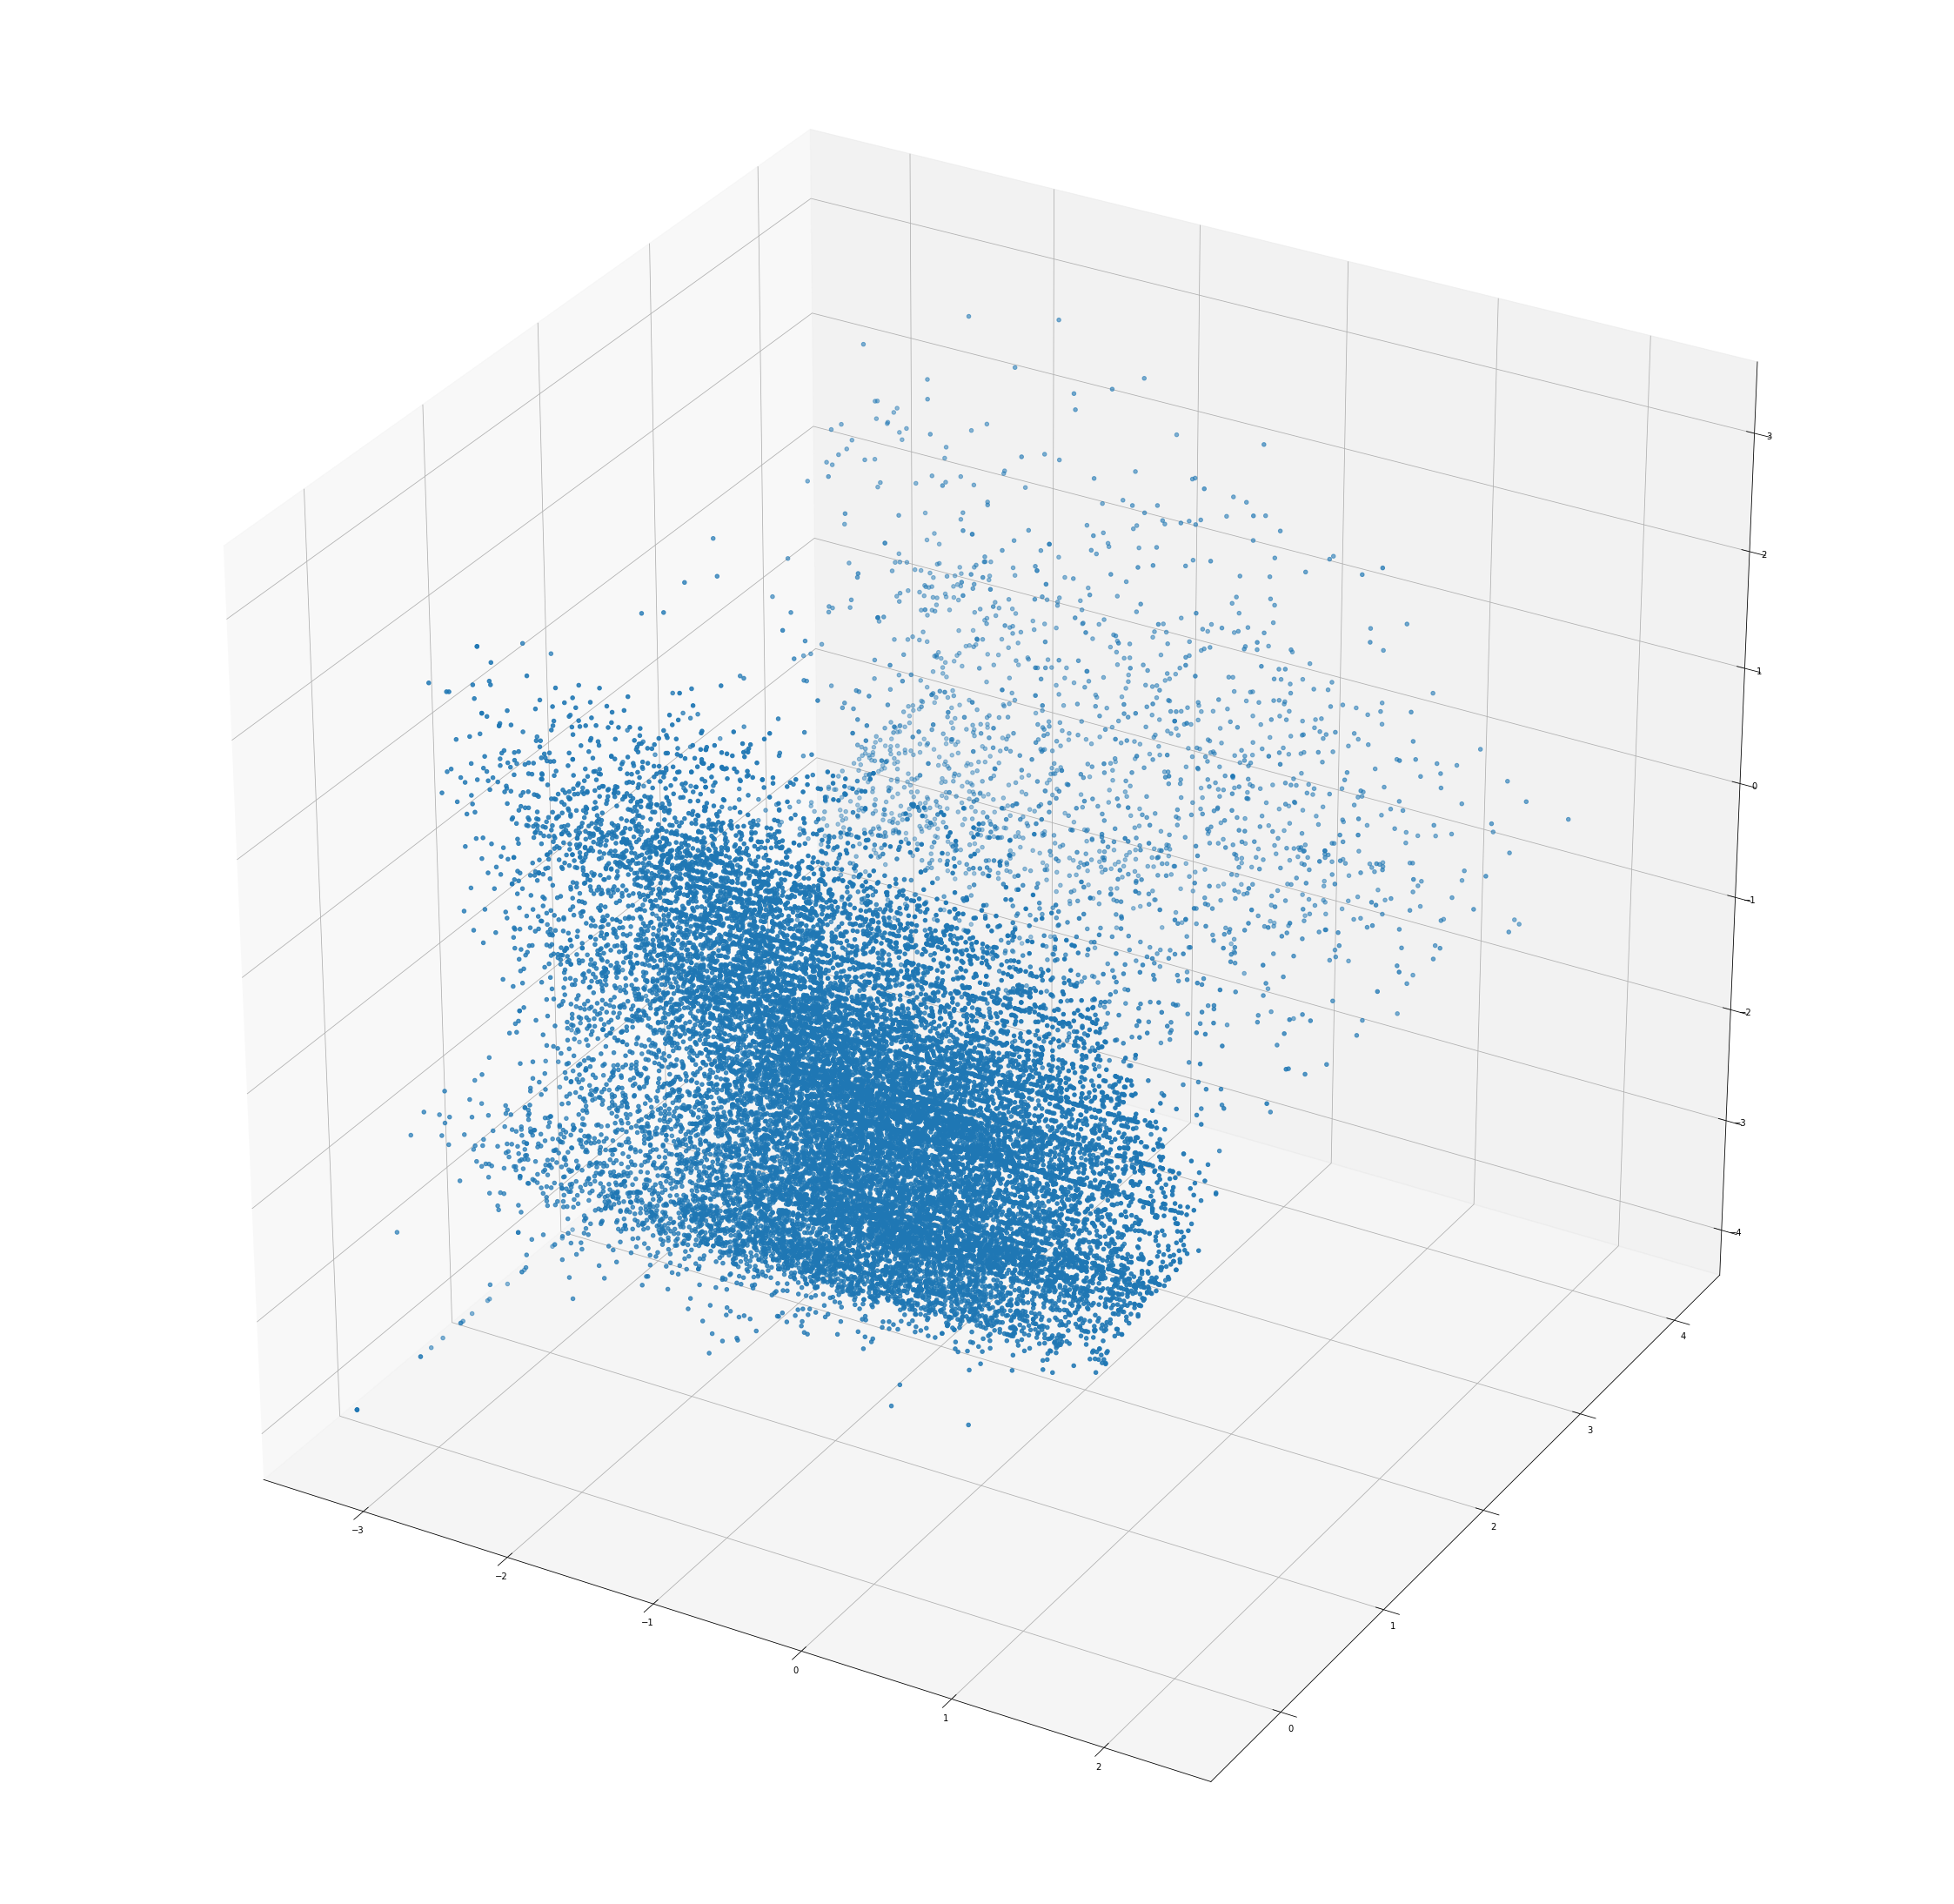

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (40, 40))
ax = fig.add_subplot(111, projection='3d')

x = df['danceability']
x = (x - x.mean()) / x.std()
y = df['instrumentalness']
y = (y - y.mean()) / y.std()
z = df['tempo']
z = (z - z.mean()) / z.std()
ax.scatter(x, y, z)
plt.show()

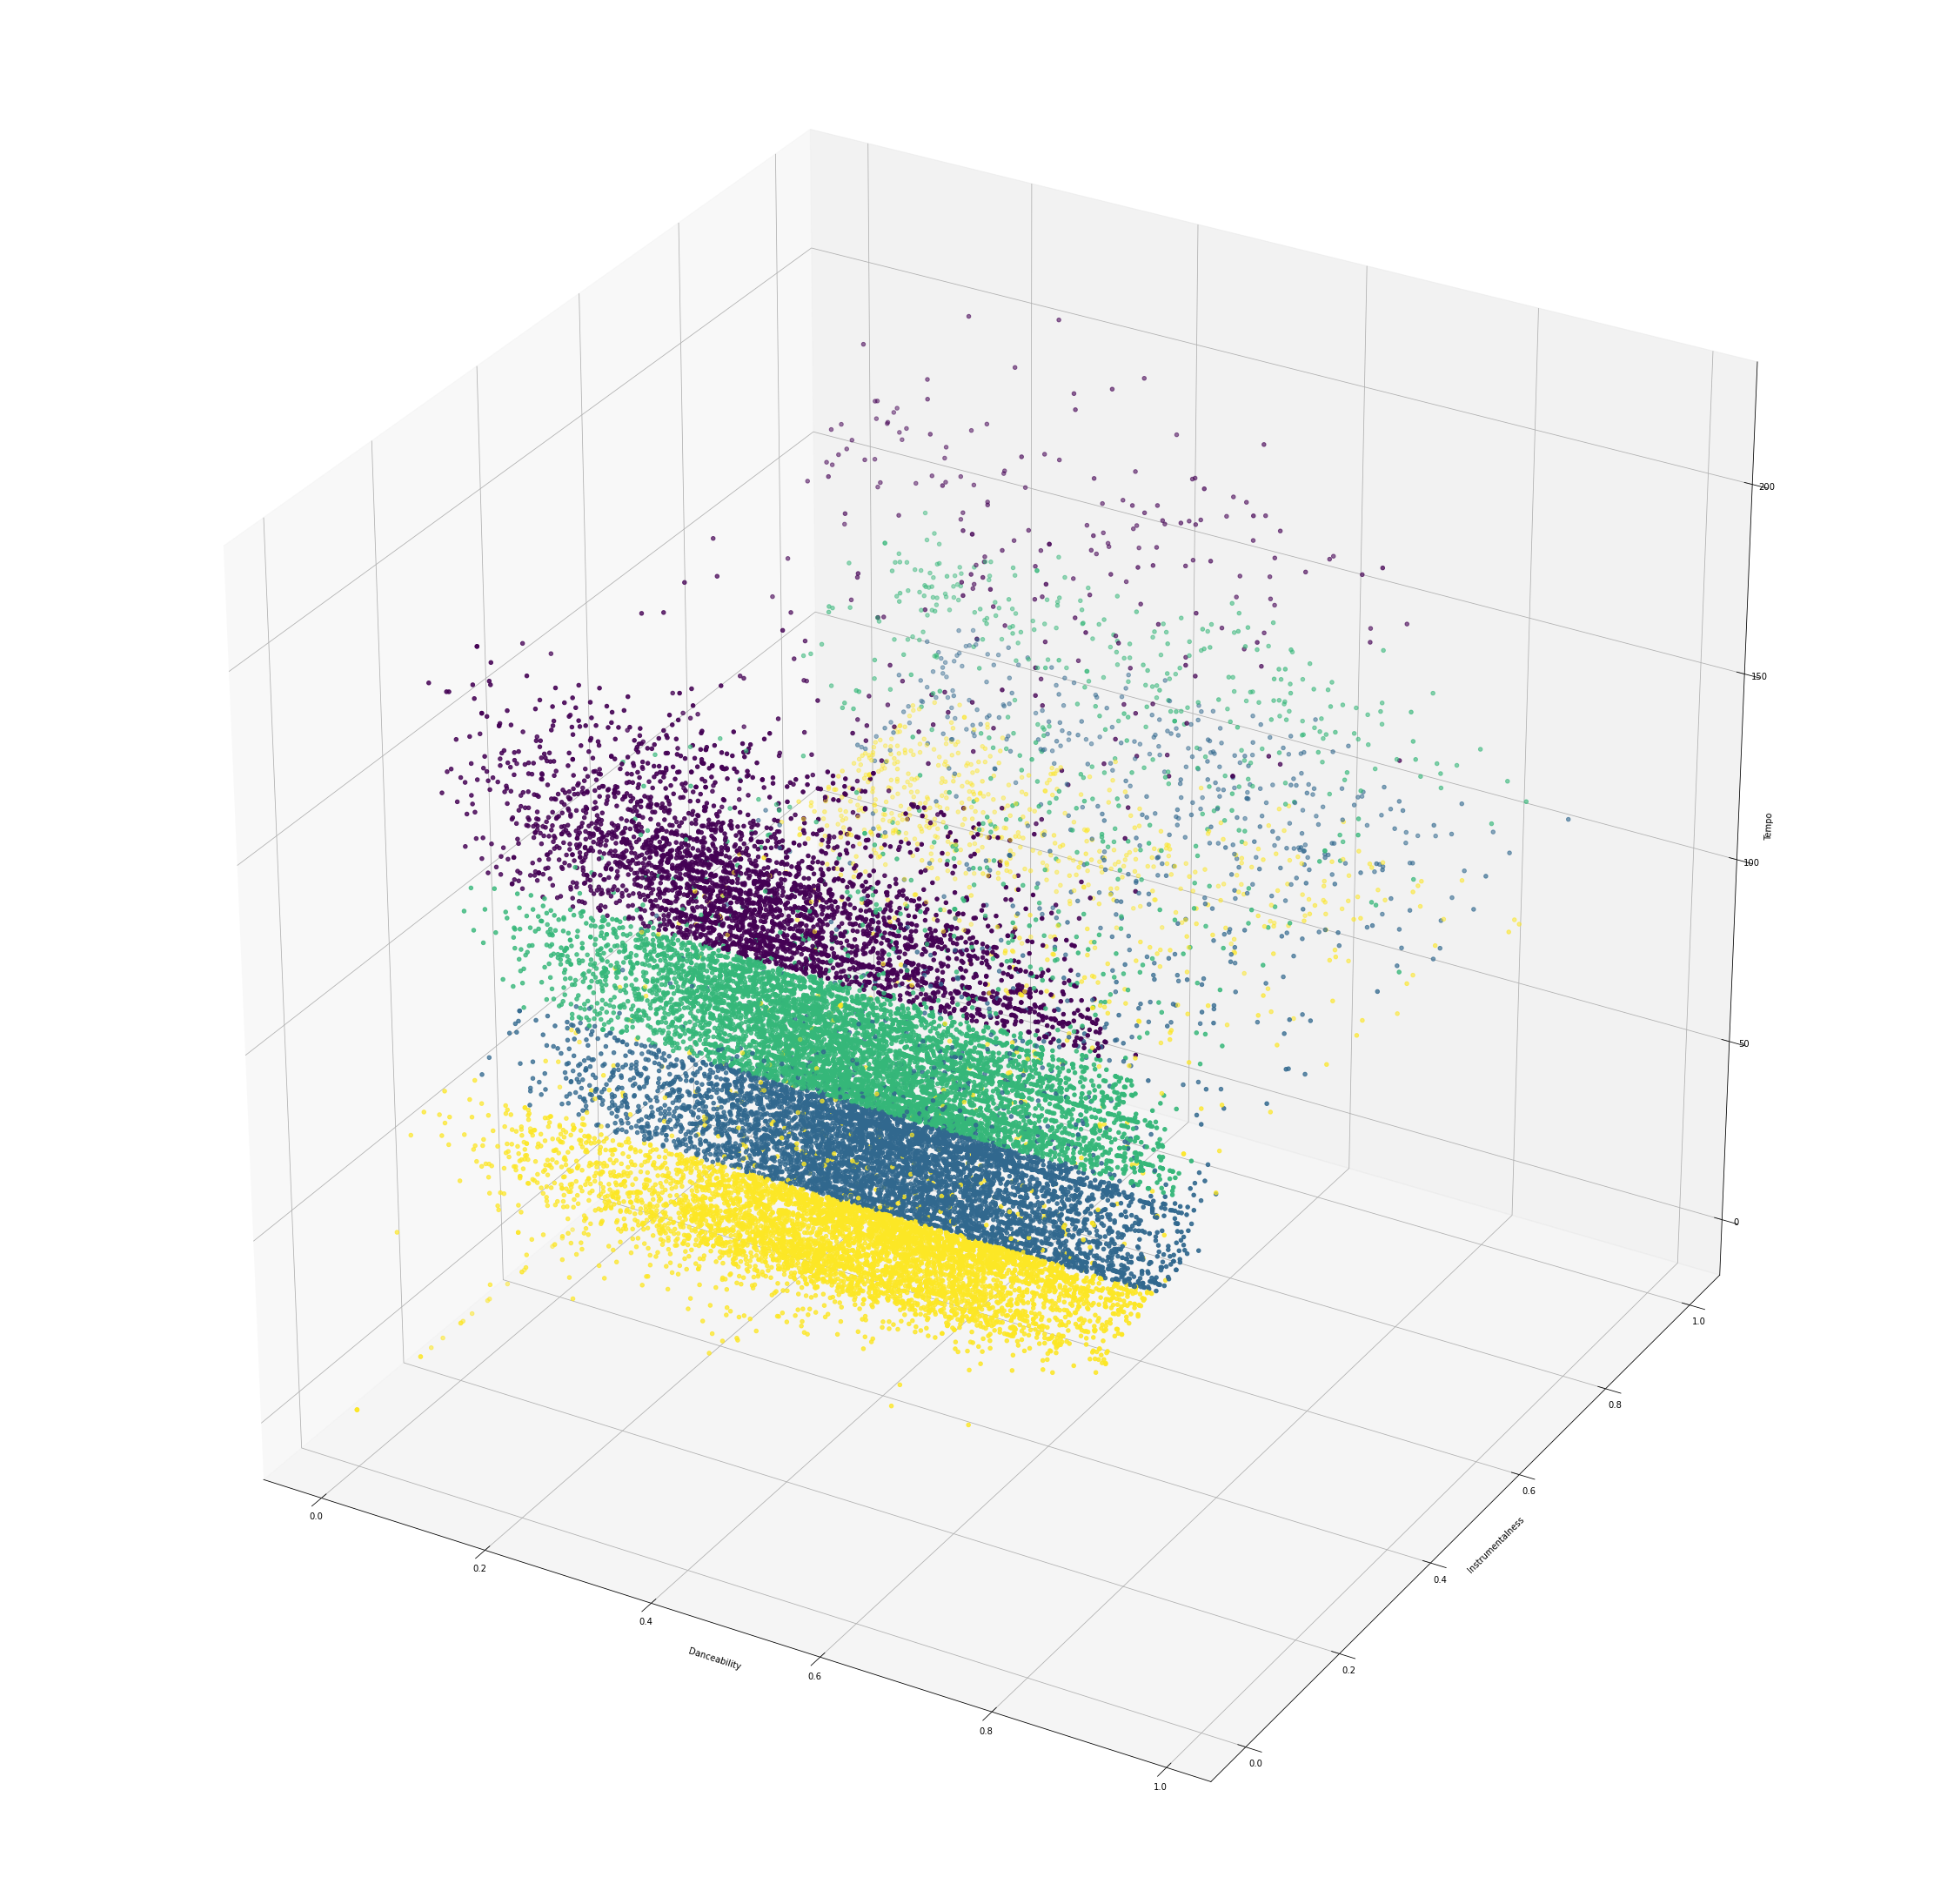

In [13]:
df_sub = df[['danceability', 'instrumentalness', 'tempo']]
kme = KMeans(n_clusters = 4)
y_sub_pred = kme.fit_predict(df_sub)
df_sub.insert(3, 'cluster', y_sub_pred, allow_duplicates = True)
fig = plt.figure(figsize = (40, 40))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_sub['danceability'],df_sub['instrumentalness'],df_sub['tempo'], c = df_sub['cluster'])
ax.set_xlabel('Danceability')
ax.set_ylabel('Instrumentalness')
ax.set_zlabel('Tempo')
plt.show()

In [14]:
def norm_df(daf):
    nrows, ncols = daf.shape
    cols = list(daf.columns.values)
    X = daf.to_numpy()
    X_norm = np.zeros((nrows, ncols))
    for i in range(ncols):
        mean = X[:,i].mean()
        std = X[:,i].std()
        X_norm[:,i] = (X[:,i] - mean) / std
    df_norm = pd.DataFrame(X_norm, columns = cols)
    return df_norm

[0.44295265 0.34875003]


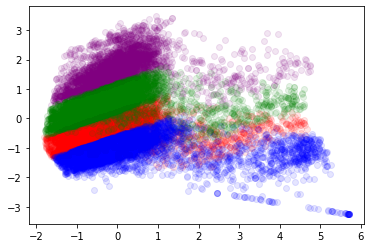

In [15]:
df_sub = df_sub[['danceability', 'instrumentalness', 'tempo']]
dfsub_norm = norm_df(df_sub)
pca_sub = PCA(n_components = 2)
sub_new = pca_sub.fit_transform(dfsub_norm)
print(pca_sub.explained_variance_ratio_)
sub_new = np.insert(sub_new, 2, y_sub_pred, axis = 1)
dfsubnew = pd.DataFrame(sub_new, columns = ['x1', 'x2', 'class'])
colors = {0:'purple', 1:'red', 2:'green', 3:'blue'}
plt.figure()
for i in range(4):
    submat = dfsubnew[dfsubnew['class'] == i].to_numpy()
    plt.scatter(submat[:,0],submat[:,1],c=colors[i], alpha = 0.1)
plt.show()

## What happens if we try clustering with more features?

[9.79276558e-01 2.06253245e-02 4.18773085e-05]


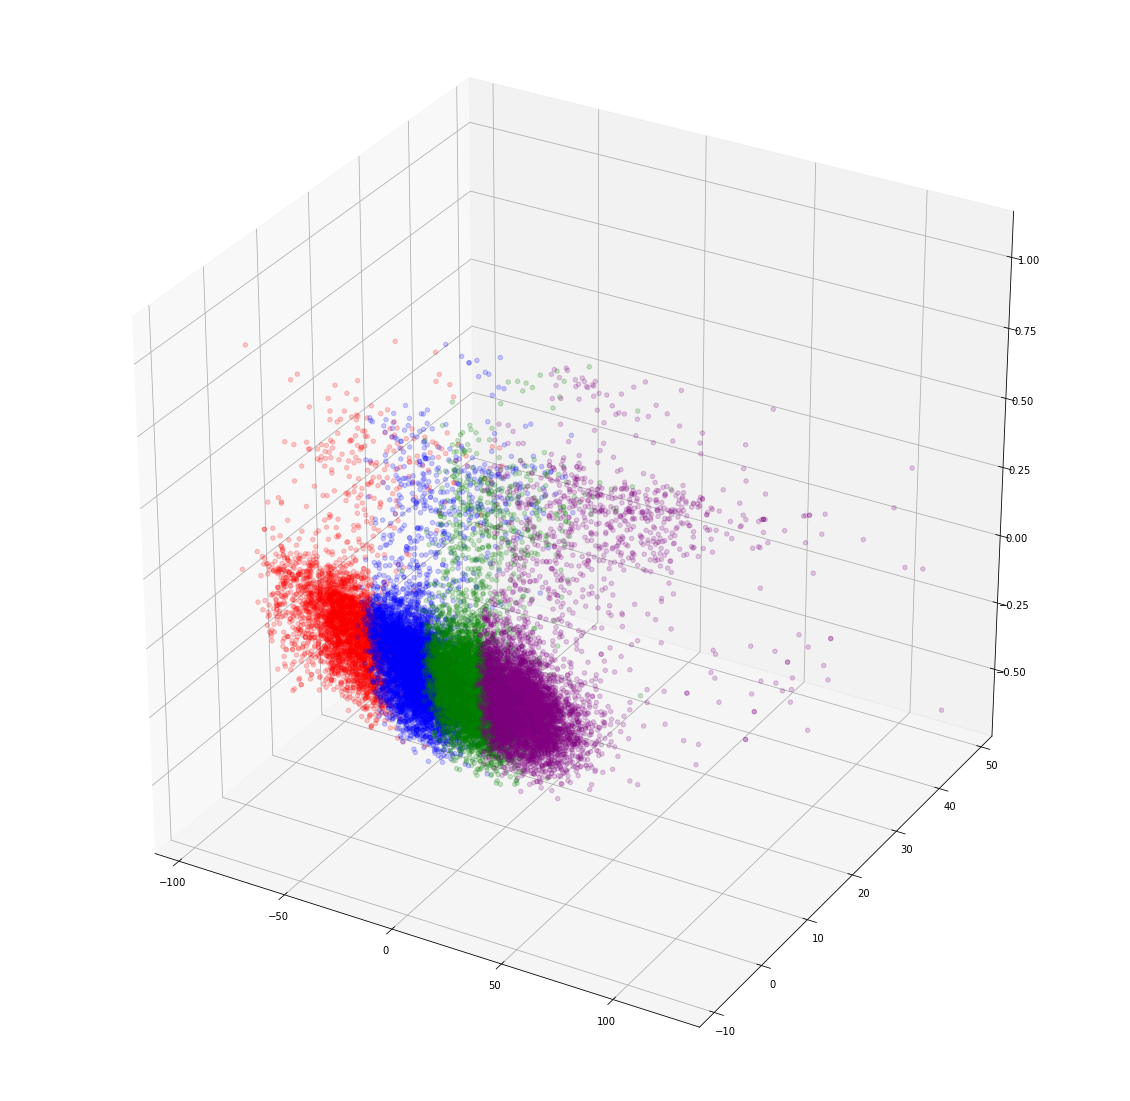

In [16]:
df_sub = df[['danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo']]
nclust = 4
kme = KMeans(n_clusters = nclust)
y_sub_pred = kme.fit_predict(df_sub)

#Now run PCA so we can visualize:
pca_sub = PCA(n_components = 3)
dfsub_norm = df_sub#norm_df(df_sub)
sub_new = pca_sub.fit_transform(dfsub_norm)
print(pca_sub.explained_variance_ratio_)
sub_new = np.insert(sub_new, 3, y_sub_pred, axis = 1)
dfsubnew = pd.DataFrame(sub_new, columns = ['x1', 'x2', 'x3', 'class'])
colors = {0:'purple', 1:'red', 2:'green', 3:'blue', 4:'orange', 5:'black', 6:'pink', 7:'gold'}

fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection='3d')
for i in range(nclust):
    submat = dfsubnew[dfsubnew['class'] == i].to_numpy()
    ax.scatter(submat[:,0],submat[:,1],submat[:,2],c=colors[i], alpha = 0.2)
plt.show()

There seems to be clustering with 4 groups in the dataset. This becomes more separable when we transform the data so that the tempo is increased exponentially.

In [17]:
df['cluster'] = y_sub_pred
grouped = df.groupby(df['cluster'])
df.groupby(df['cluster'])[['tempo', 'loudness']].describe()

tempo                                                       \
          count        mean        std      min        25%       50%   
cluster                                                                
0        6120.0   84.198662  12.015612    0.000   79.02550   85.7635   
1        3587.0  170.684570  12.238815  153.623  160.10200  169.5340   
2        6391.0  110.600535   7.842397   97.126  103.87550  110.5490   
3        6678.0  136.651258   8.316043  123.649  129.38125  136.0620   

                            loudness                                        \
               75%      max    count      mean       std     min       25%   
cluster                                                                      
0         92.19075   98.224   6120.0 -8.876003  6.174466 -60.000 -10.04100   
1        176.99350  216.020   3587.0 -6.365409  3.548545 -38.105  -7.42250   
2        118.00800  123.631   6391.0 -7.181280  3.736213 -47.452  -8.61600   
3        143.71525  153.616   6678.0 -7.025344  3.774113 -37.221  -8.28875   

                                 
            50%      75%    max  
cluster                          
0       -7.0020 -5.20950  0.161  
1       -5.5930 -4.24400  0.175  
2       -6.3290 -4.79100  1.342  
3       -6.1825 -4.67625 -0.276